# In case you not have instaled FastAI yet:

In [0]:
#!curl -s https://course.fast.ai/setup/colab | bash

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Enable fastai to save and/or load data from your google dirve:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import what we will need:

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from fastai.basics import Learner
from fastai.callbacks.tracker import SaveModelCallback
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

In [0]:
bs = 64 #our bacth size

In [6]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/beagle_140.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_71.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_142.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_38.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_55.jpg')]

In [0]:
np.random.seed(42)
pat = r'/([^/]+)_\d+.jpg$'

# We are going to play with ResNet-50:

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=[224,224], bs=bs//2).normalize(imagenet_stats)

In [0]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Union[Collection[fastai.vision.image.Transform], NoneType]=None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



# Data augumentation

In [0]:
def get_ex(): return open_image('/root/.fastai/data/oxford-iiit-pet/images/beagle_140.jpg')

In [0]:
tfms = get_transforms(max_rotate=25)
len(tfms)

2

In [0]:
def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

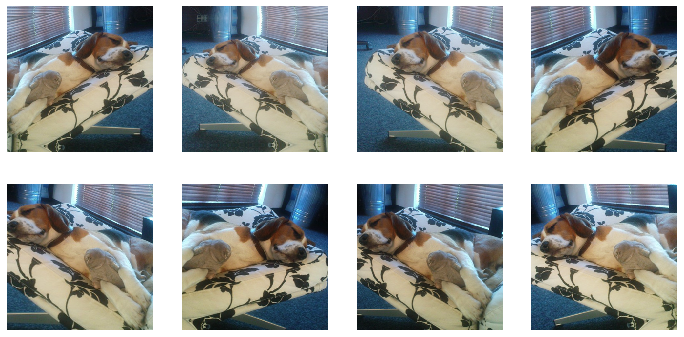

In [0]:
plots_f(2, 4, 12, 6, size=299)

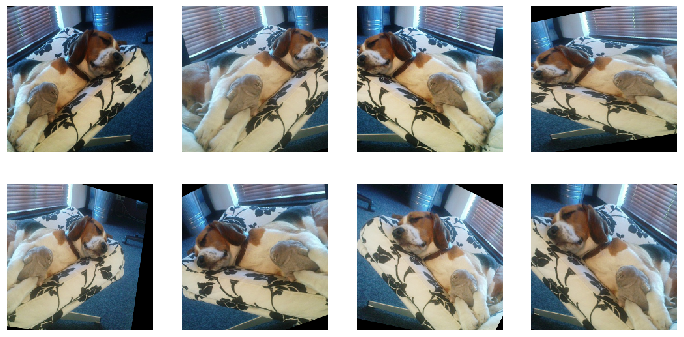

In [0]:
plots_f(2, 4, 12, 6, size=224, padding_mode='zeros')

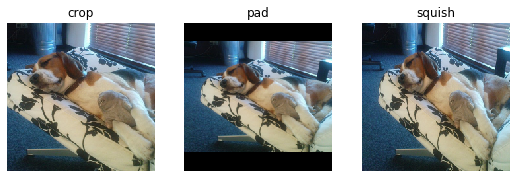

In [0]:
_,axs = plt.subplots(1,3,figsize=(9,3))
for rsz,ax in zip([ResizeMethod.CROP, ResizeMethod.PAD, ResizeMethod.SQUISH], axs):
    get_ex().apply_tfms([crop_pad()], size=224, resize_method=rsz, padding_mode='zeros').show(ax=ax, title=rsz.name.lower())

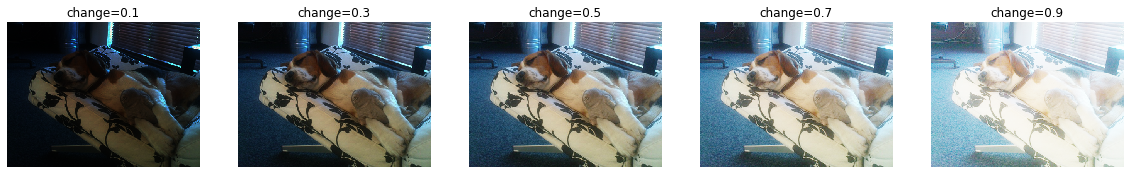

In [0]:
fig, axs = plt.subplots(1,5,figsize=(20,12))
for change, ax in zip(np.linspace(0.1,0.9,5), axs):
    brightness(get_ex(), change).show(ax=ax, title=f'change={change:.1f}')

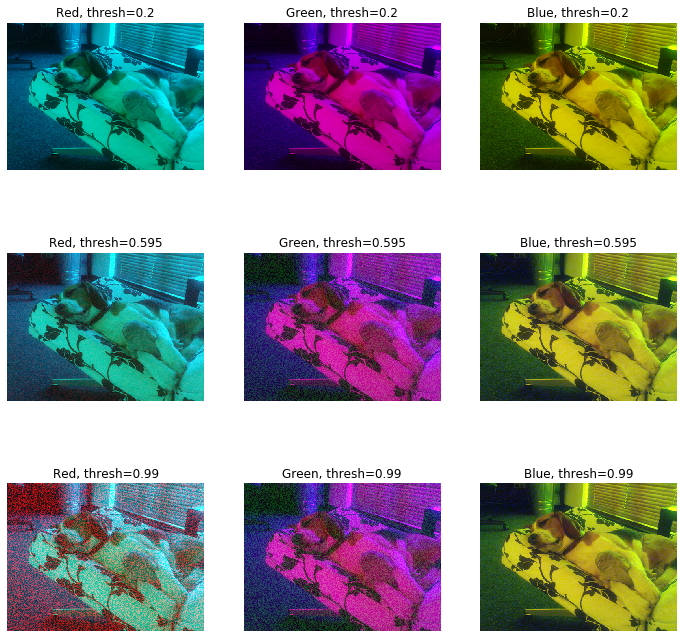

In [0]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
channels = ['Red', 'Green', 'Blue']

for i in np.arange(0, 3):
    for thresh, ax in zip(np.linspace(0.2, 0.99, 3), axs[:, i]):
        get_ex().rgb_randomize(channel = i, thresh = thresh).show(
            ax=ax, title = f'{channels[i]}, thresh={thresh}')

We can build our CNN model using the ResNet-50 as base model

In [0]:
help(models)

Help on package fastai.vision.models in fastai.vision:

NAME
    fastai.vision.models

PACKAGE CONTENTS
    cadene_models
    darknet
    efficientnet
    presnet
    unet
    wrn
    xception
    xresnet
    xresnet2

DATA
    xresnet101 = functools.partial(<function xresnet at 0x7f69674...ion=4,...
    xresnet152 = functools.partial(<function xresnet at 0x7f69674...ion=4,...
    xresnet18 = functools.partial(<function xresnet at 0x7f69674...nsion=1...
    xresnet34 = functools.partial(<function xresnet at 0x7f69674...nsion=1...
    xresnet50 = functools.partial(<function xresnet at 0x7f69674...nsion=4...

FILE
    /usr/local/lib/python3.6/dist-packages/fastai/vision/models/__init__.py




In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy],callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 39.2MB/s]


# A little bit of fine-tuning

## Weight decay:

In [0]:
@dataclass
class wd_finder:
    learn: Learner
    wd:Union[int,Callable] = None
    
    def __post_init__(self, **kwargs):
        self.wd_list = listify(self.wd)
        self.wd_recorder = []
        
        if self.wd is None:
            self.wd_list = [0,1e-1,1e-3,1e-5]
            
        for wd in self.wd_list:
            self.learn.lr_find(wd=self.wd,**kwargs)
            self.wd_recorder.append(self.learn.recorder)
            
    def plot_wd(self, skip_start:int=10, skip_end:int=5)->None:
        _, ax = plt.subplots(1,1)
        
        for k, i in enumerate(self.wd_recorder):
            losses = i.losses[skip_start:-skip_end] if skip_end > 0 else i.losses[skip_start:]
            lrs = i.lrs[skip_start:-skip_end] if skip_end > 0 else i.lrs[skip_start:]
            ax.plot(lrs, losses, label='WD={}'.format(self.wd_list[k]))
            ax.set_xlabel('Learning Rate')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.set_xscale('log')

In [0]:
find_wd = wd_finder(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


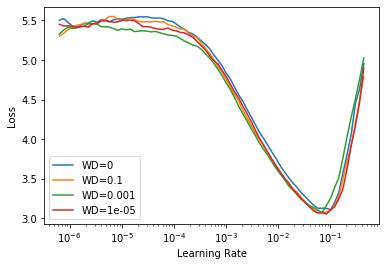

In [0]:
find_wd.plot_wd()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.666193,0.633727,0.154939,0.845061,01:51
1,0.922142,0.585982,0.162382,0.837618,01:50
2,0.954760,0.901970,0.255751,0.744249,01:50
3,0.784540,0.597432,0.152909,0.847091,01:52
4,0.592597,0.464585,0.129229,0.870771,01:52
5,0.376132,0.280725,0.092016,0.907984,01:49
6,0.231100,0.229669,0.077808,0.922192,01:48
7,0.169746,0.242672,0.069689,0.930311,01:49


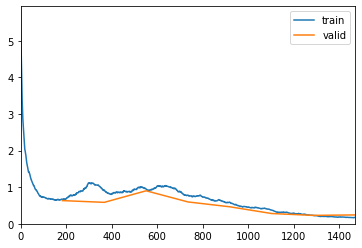

In [0]:
learn.fit_one_cycle(8,max_lr=slice(1e-3,3e-2),wd=0.1)

In [0]:
learn.save('/content/gdrive/My Drive/stage-1-50')

# Mixup


# What is mixup?

As the name kind of suggests, the authors of the mixup article propose to train the model on a mix of the pictures of the training set. Let's say we're on CIFAR10 for instance, then instead of feeding the model the raw images, we take two (which could be in the same class or not) and do a linear combination of them: in terms of tensor it's

new_image = t * image1 + (1-t) * image2

where t is a float between 0 and 1. Then the target we assign to that image is the same combination of the original targets:

new_target = t * target1 + (1-t) * target2

assuming your targets are one-hot encoded (which isn't the case in pytorch usually). And that's as simple as this.


In [0]:
def get_a(): return open_image('/root/.fastai/data/oxford-iiit-pet/images/beagle_140.jpg')
def get_b(): return open_image('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_55.jpg')

In [0]:
img_a = get_a().apply_tfms([crop_pad()],size=224)
img_b = get_b().apply_tfms([crop_pad()],size=224)

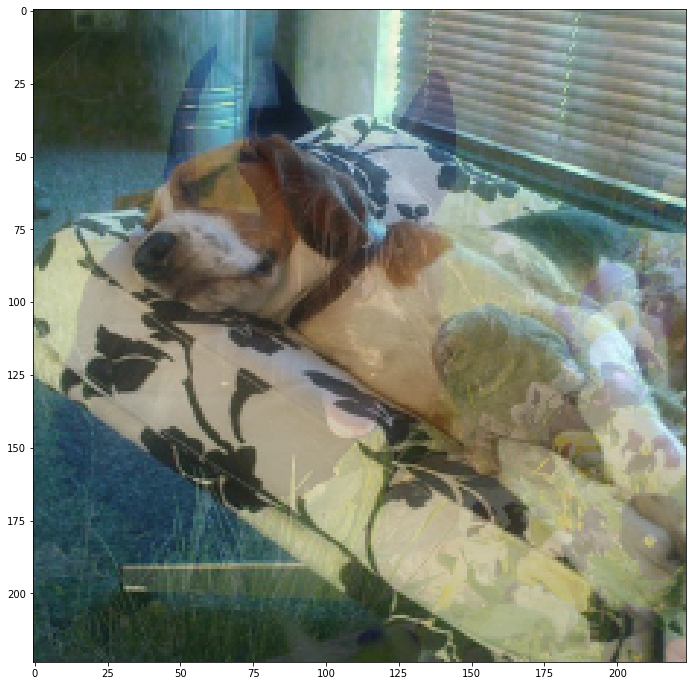

In [0]:
mixed_up = img_a.data * 0.8 + img_b.data * 0.2
plt.figure(figsize=[12,12])
plt.imshow(mixed_up.permute(1,2,0));

## Implementation

In [0]:
# PyTorch has a log-gamma but not a gamma, so we'll create one
Γ = lambda x: x.lgamma().exp()

In [0]:
facts = [math.factorial(i) for i in range(7)]

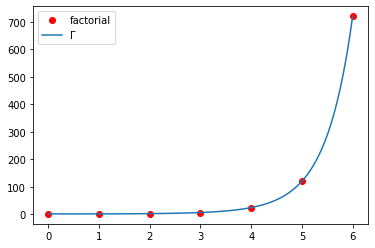

In [0]:
plt.plot(range(7), facts, 'ro')
plt.plot(torch.linspace(0,6), Γ(torch.linspace(0,6)+1))
plt.legend(['factorial','Γ']);



In the original article, the authors suggested three things:

    - Create two separate dataloaders and draw a batch from each at every iteration to mix them up
    - Draw a t value following a beta distribution with a parameter α (0.4 is suggested in their article)
    - Mix up the two batches with the same value t.
    - Use one-hot encoded targets

Why the beta distribution with the same parameters α? Well it looks like this:


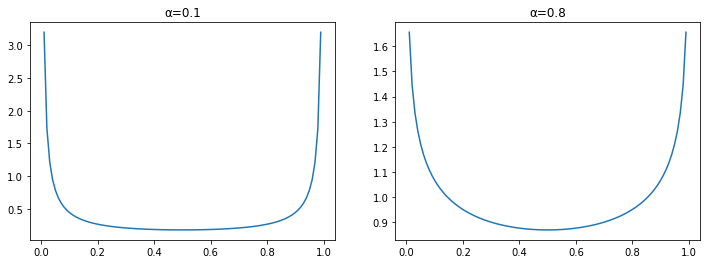

In [0]:
_,axs = plt.subplots(1,2, figsize=(12,4))
x = torch.linspace(0,1, 100)
for α,ax in zip([0.1,0.8], axs):
    α = tensor(α)
#     y = (x.pow(α-1) * (1-x).pow(α-1)) / (gamma_func(α ** 2) / gamma_func(α))
    y = (x**(α-1) * (1-x)**(α-1)) / (Γ(α)**2 / Γ(2*α))
    ax.plot(x,y)
    ax.set_title(f"α={α:.1}")

While the approach above works very well, it's not the fastest way we can do this. The main point that slows down this process is wanting two different batches at every iteration (which means loading twice the amount of images and applying to them the other data augmentation function). To avoid this slow down, we can be a little smarter and mixup a batch with a shuffled version of itself (this way the images mixed up are still different). This was a trick suggested in the MixUp paper.

Then pytorch was very careful to avoid one-hot encoding targets when it could, so it seems a bit of a drag to undo this. Fortunately for us, if the loss is a classic cross-entropy, we have:

  loss(output, new_target) = t * loss(output, target1) + (1-t) * loss(output, target2)

so we won't one-hot encode anything and just compute those two losses then do the linear combination.

Using the same parameter t for the whole batch also seemed a bit inefficient. In our experiments, we noticed that the model can train faster if we draw a different t for every image in the batch (both options get to the same result in terms of accuracy, it's just that one arrives there more slowly). The last trick we have to apply with this is that there can be some duplicates with this strategy: let's say or shuffle say to mix image0 with image1 then image1 with image0, and that we draw t=0.1 for the first, and t=0.9 for the second. Then

image0 * 0.1 + shuffle0 * (1-0.1) = image0 * 0.1 + image1 * 0.9
image1 * 0.9 + shuffle1 * (1-0.9) = image1 * 0.9 + image0 * 0.1

will be the same. Of course, we have to be a bit unlucky but in practice, we saw there was a drop in accuracy by using this without removing those near-duplicates. To avoid them, the tricks is to replace the vector of parameters we drew by

t = max(t, 1-t)

The beta distribution with the two parameters equal is symmetric in any case, and this way we insure that the biggest coefficient is always near the first image (the non-shuffled batch).

In Mixup we have handle loss functions that have an attribute reduction (like nn.CrossEntropy()). To deal with the reduction=None with various types of loss function without modifying the actual loss function outside of the scope we need to perform those operations with no reduction, we create a context manager:


In [0]:
class NoneReduce():
    def __init__(self, loss_func): 
        self.loss_func,self.old_red = loss_func,None
        
    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = getattr(self.loss_func, 'reduction')
            setattr(self.loss_func, 'reduction', 'none')
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')
        
    def __exit__(self, type, value, traceback):
        if self.old_red is not None: setattr(self.loss_func, 'reduction', self.old_red)

In [0]:
from torch.distributions.beta import Beta

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [0]:
def lin_comb(v1,v2,beta): return beta*v1 + (1-beta)*v2

In [0]:
class MixUp(Callback):
    _order = 90 #Runs after normalization and cuda
    def __init__(self, α:float=0.4): self.distrib = Beta(tensor([α]), tensor([α]))
    
    def begin_fit(self): self.old_loss_func,self.run.loss_func = self.run.loss_func,self.loss_func
    
    def begin_batch(self):
        if not self.in_train: return #Only mixup things during training
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        λ = torch.stack([λ, 1-λ], 1)
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.λ)
        
    def after_fit(self): self.run.loss_func = self.old_loss_func
    
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = lin_comb(loss1, loss2, self.λ)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))


Label smoothing

Another regularization technique that's often used is label smoothing. It's designed to make the model a little bit less certain of it's decision by changing a little bit its target: instead of wanting to predict 1 for the correct class and 0 for all the others, we ask it to predict 1-ε for the correct class and ε for all the others, with ε a (small) positive number and N the number of classes. This can be written as:
$$loss = (1-ε) ce(i) + ε \sum ce(j) / N$$

where ce(x) is cross-entropy of x (i.e. $-\log(p_{x})$), and i is the correct class. This can be coded in a loss function:


In [0]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

In [17]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy], 
                    loss_func=LabelSmoothingCrossEntropy(),callbacks=MixUp())

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 31.1MB/s]


In [18]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [0]:
find_wd = wd_finder(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


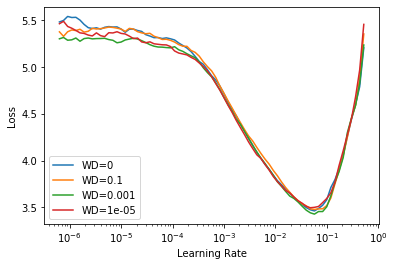

In [0]:
find_wd.plot_wd()

In [19]:
learn.fit_one_cycle(8,max_lr=slice(1e-3,3e-2),wd=0.1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.557478,1.524299,0.204330,0.795670,01:40
1,1.372652,1.286827,0.177943,0.822057,01:38
2,1.470486,1.643370,0.269283,0.730717,01:38
3,1.409825,1.238863,0.171854,0.828146,01:37
4,1.183893,1.101953,0.129905,0.870095,01:37
5,1.049419,1.012431,0.102165,0.897835,01:37
6,0.928600,0.939447,0.081867,0.918133,01:38
7,0.873086,0.912141,0.069689,0.930311,01:37


# The GradCam (what the CNN is learning):

In [0]:
m = learn.model.eval();

Category english_setter

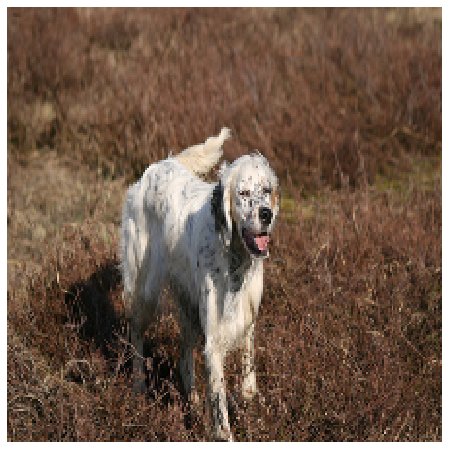

In [21]:
idx = 52
x,y = data.valid_ds[idx]
x.show(figsize=(8,8))
data.valid_ds.y[idx]

In [22]:
x.shape

torch.Size([3, 224, 224])

In [0]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [0]:
hook_a, hook_g = hooked_backward()

In [27]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 7, 7])

In [28]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [0]:
def show_heatmap(hm):
    fig, ax = plt.subplots(figsize=(8,8))
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
             interpolation='bilinear', cmap='magma')

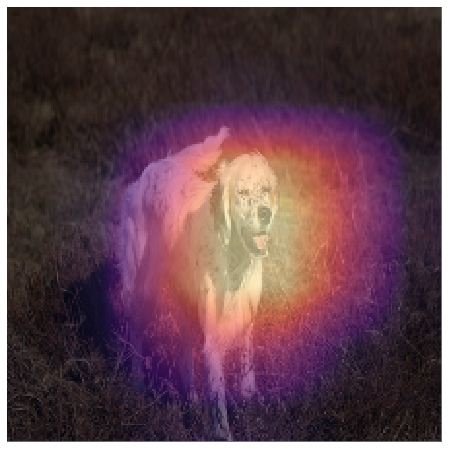

In [30]:
show_heatmap(avg_acts)

In [31]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([2048, 7, 7]), torch.Size([2048]))

In [0]:
mult = (acts*grad_chan[...,None,None]).mean(0)

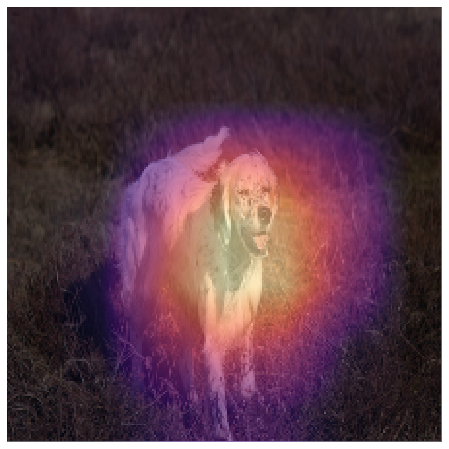

In [33]:
show_heatmap(mult)